# Imports

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')

In [4]:
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
# xb: nb-by-d
xb.shape, yb.shape

((109539, 512), (109539,))

In [6]:
#xq: nq-by-d (query vectors)
xq.shape, yq.shape

((7738, 512), (7738,))

In [5]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 1323)

In [6]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [7]:
xb.max()

359338.03

In [8]:
faiss.normalize_L2(xb)

In [9]:
xb.max()

0.7638167

In [10]:
index.train(xb)

In [11]:
index.add_with_ids(xb, yb)

In [12]:
print(index.is_trained)
print(index.ntotal)

True
109539


## Train dataset

In [13]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 843  843  356  843  356]
 [ 610  610  610  610  610]
 [ 703  703  703  703  538]
 [ 134   65  465  886  237]
 [ 544  544  544  544 1098]]
[[843]
 [610]
 [703]
 [134]
 [544]]
[[1.0000001  0.91211677 0.9093743  0.9092268  0.90197533]
 [1.         0.97553444 0.94988906 0.9396661  0.936189  ]
 [0.9999998  0.9999718  0.9999683  0.9999517  0.9999446 ]
 [1.0000001  0.8156876  0.81413096 0.8103752  0.80966973]
 [1.0000001  0.9206761  0.907807   0.8687527  0.8659712 ]]


In [14]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [15]:
I_train[:,0].shape, yb.shape

((109539,), (109539,))

In [16]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

0.999881320808114

In [17]:
I_train[:10,0], yb[:10]

(array([843, 610, 703, 134, 544, 738, 509, 369, 171, 942]),
 array([843, 610, 703, 134, 544, 738, 509, 369, 171, 942]))

In [18]:
I_train[-10:,0], yb[-10:]

(array([ 738,  608,  397,  334,  406,  210,  912, 1009,  552,  937]),
 array([ 738,  608,  397,  334,  406,  210,  912, 1009,  552,  937]))

### Train confusion matrix

In [19]:
#cm = confusion_matrix(I_train[:,0], yb)

In [22]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [22]:
xq.max()

73.71411

In [23]:
faiss.normalize_L2(xq)

In [24]:
xq.max()

0.46406218

In [25]:
D_valid, I_valid = index.search(xq, k) # actual search

In [26]:
xq.shape, yq.shape

((7738, 512), (7738,))

In [27]:
I_valid.shape, D_valid.shape

((7738, 5), (7738, 5))

In [28]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[352 352 352 352 352]
 [361 361 361 361 361]
 [810 810 810 810 810]
 [505 505 505 505 505]
 [647  91 775 775  91]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.7474127  0.7199716  0.6405589  0.6269395  0.6243063 ]
 [0.87877285 0.87220675 0.8664288  0.8660873  0.8460343 ]
 [0.8590394  0.81852    0.8137456  0.7989551  0.7517146 ]
 [0.9385084  0.9238536  0.9147873  0.9129464  0.9128064 ]
 [0.86378586 0.8298116  0.8146833  0.80633307 0.78924155]]


In [29]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 103  728  474  728  728]
 [ 202  202  202  202  202]
 [ 824  824  824  824  824]
 [1045 1045 1045 1045  378]
 [ 680  882  882  882  882]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.798312   0.7754725  0.7355064  0.73252404 0.7319523 ]
 [0.9374063  0.92792326 0.92631704 0.9255649  0.91990906]
 [0.7210665  0.69770104 0.6966473  0.6922716  0.68993825]
 [0.73019606 0.700495   0.68478316 0.66379094 0.65677834]
 [0.6041517  0.5953274  0.5952405  0.57868755 0.5780088 ]]


In [30]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [31]:
I_valid[:,0]

array([ 352,  361,  810, ...,  824, 1045,  680])

In [32]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [33]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

5029

In [34]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.6499095373481519

In [35]:
valid_correct = np.equal(I_valid[:,0], yq)

In [36]:
valid_correct

array([ True,  True, False, ...,  True, False, False])

In [37]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [38]:
cm = confusion_matrix(I_valid[:,0], yq)

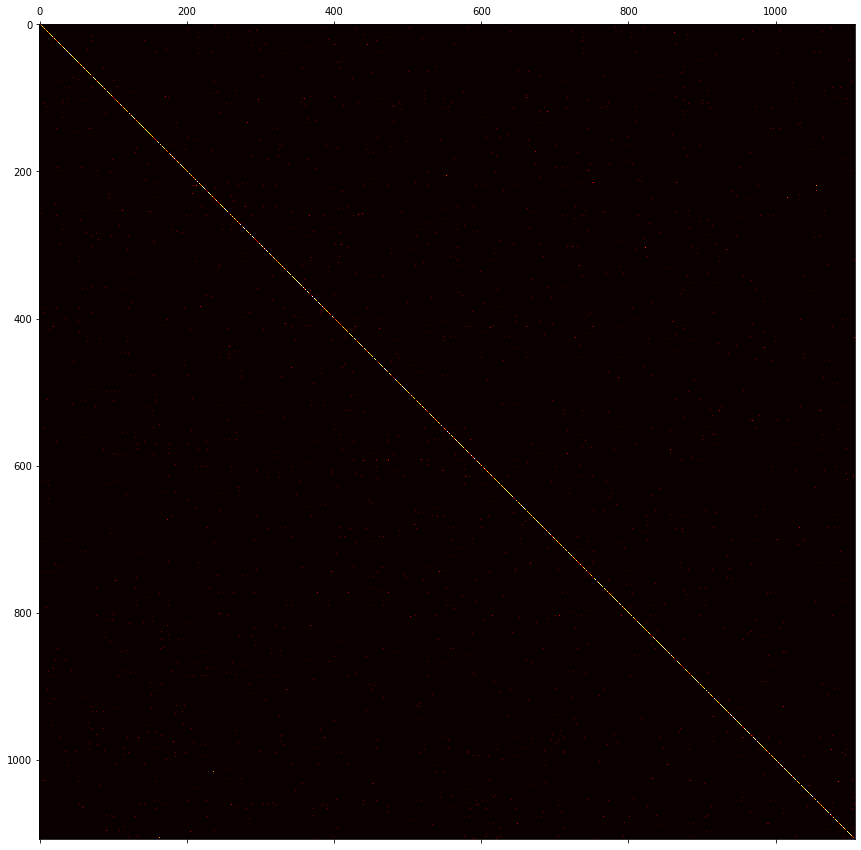

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [19]:
xq_test = np.load('pred/feats_test.npy')

In [20]:
xq_test.max()

229403.6

In [21]:
faiss.normalize_L2(xq_test)

In [22]:
xq_test.max()

0.7747844

In [23]:
D_test, I_test = index.search(xq_test, k) # actual search

In [24]:
xq_test.shape, I_test.shape, D_test.shape

((19897, 512), (19897, 5), (19897, 5))

In [25]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 855  110  110  110  591]
 [ 104 1095  458 1061 1095]
 [ 832  794  935  288  574]
 [ 855  455   17   17  855]
 [ 645 1095  297  104  602]]
[[0.9028249  0.8322381  0.82952213 0.81576633 0.81137717]
 [0.8871302  0.8529123  0.8336724  0.82957107 0.8249299 ]
 [0.8585765  0.8550389  0.84294164 0.8327428  0.8309396 ]
 [0.6785813  0.66819894 0.66583455 0.64398646 0.6436701 ]
 [0.8625626  0.8601617  0.8559202  0.85454786 0.8522544 ]]


In [26]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 490  338  250  338  338]
 [  49  990 1085  937 1091]
 [ 380  382  926 1087  947]
 [ 963  504  135  490  490]
 [ 490  338  338  338  338]]
[[0.78148973 0.7752568  0.76782304 0.74911094 0.7409553 ]
 [0.83846027 0.80423504 0.7902498  0.7882857  0.7822853 ]
 [0.83882225 0.8371389  0.82463336 0.82378405 0.8138429 ]
 [0.9462569  0.92662704 0.92316365 0.91902673 0.91883147]
 [0.8078413  0.7674887  0.7501066  0.74634564 0.7446472 ]]


In [27]:
I_test[2]

array([832, 794, 935, 288, 574])

In [28]:
np.unique(I_test[2], return_counts=True)

(array([288, 574, 794, 832, 935]), array([1, 1, 1, 1, 1]))

In [29]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [30]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)